In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
df = pd.read_csv('data/combined_df.csv', sep=',', header=0)
df = df.groupby(['NTDID', 'Agency', 'City', 'State']).sum().reset_index()
df.head(2)

,NTDID,Agency,City,State,Member ID,Number of Stations,Number of Bus/Rail Stops,Service Area,Service Pop.,Passenger Miles,Passenger Trips,Avg. Trip Length,Transportation Modes
0,1,King County Department of Metro Transit,Seattle,WA,257,23,8031,2134.0,2260800.0,259894650.0,60165932.0,4.319631,7
1,2,Spokane Transit Authority,Spokane,WA,262,16,1689,248.0,442499.0,28337075.0,6114361.0,4.634511,3


In [3]:
# Load the Revenue data

trips_df = pd.read_excel('data/February 2022 Raw database.xlsx', sheet_name="UPT")
trips_df = trips_df[trips_df['Active'] == 'Active'].groupby(['5 digit NTD ID', 'Agency']).sum().reset_index()
trips_df.head(2)

,5 digit NTD ID,Agency,UZA,JAN02,FEB02,MAR02,APR02,MAY02,JUN02,JUL02,...,MAY21,JUN21,JUL21,AUG21,SEP21,OCT21,NOV21,DEC21,JAN22,FEB22
0,1.0,King County Department of Metro Transit,112.0,8399860.0,7522857.0,8344897.0,8400045.0,8510813.0,7853696.0,8238762.0,...,4148694.0,4458771.0,4877298.0,4854160.0,5062069.0,5521458.0,5008119.0,4336861.0,4464492.0,4415506.0
1,2.0,Spokane Transit Authority,384.0,796243.0,698596.0,715847.0,718294.0,720974.0,598705.0,593403.0,...,447824.0,452861.0,454195.0,460404.0,499800.0,541122.0,507874.0,481270.0,479878.0,496804.0


In [4]:
# combine the dataframes

trips_combined_df = df.merge(trips_df, left_on=['NTDID','Agency'], right_on=['5 digit NTD ID', 'Agency'], how='inner')
trips_combined_df['Stops'] = trips_combined_df['Number of Stations'] + trips_combined_df['Number of Bus/Rail Stops']
trips_combined_df.head(2)

,NTDID,Agency,City,State,Member ID,Number of Stations,Number of Bus/Rail Stops,Service Area,Service Pop.,Passenger Miles,...,JUN21,JUL21,AUG21,SEP21,OCT21,NOV21,DEC21,JAN22,FEB22,Stops
0,1,King County Department of Metro Transit,Seattle,WA,257,23,8031,2134.0,2260800.0,259894650.0,...,4458771.0,4877298.0,4854160.0,5062069.0,5521458.0,5008119.0,4336861.0,4464492.0,4415506.0,8054
1,2,Spokane Transit Authority,Spokane,WA,262,16,1689,248.0,442499.0,28337075.0,...,452861.0,454195.0,460404.0,499800.0,541122.0,507874.0,481270.0,479878.0,496804.0,1705


In [5]:
trips_filtered_df = trips_combined_df.groupby(['City','State']).sum().reset_index()
trips_included_columns = ['JAN02','FEB02','MAR02','APR02','MAY02','JUN02','JUL02','AUG02','SEP02','OCT02','NOV02','DEC02',
                        'JAN03','FEB03','MAR03','APR03','MAY03','JUN03','JUL03','AUG03','SEP03','OCT03','NOV03','DEC03',
                        'JAN04','FEB04','MAR04','APR04','MAY04','JUN04','JUL04','AUG04','SEP04','OCT04','NOV04','DEC04',
                        'JAN05','FEB05','MAR05','APR05','MAY05','JUN05','JUL05','AUG05','SEP05','OCT05','NOV05','DEC05',
                        'JAN06','FEB06','MAR06','APR06','MAY06','JUN06','JUL06','AUG06','SEP06','OCT06','NOV06','DEC06',
                        'JAN07','FEB07','MAR07','APR07','MAY07','JUN07','JUL07','AUG07','SEP07','OCT07','NOV07','DEC07',
                        'JAN08','FEB08','MAR08','APR08','MAY08','JUN08','JUL08','AUG08','SEP08','OCT08','NOV08','DEC08',
                        'JAN09','FEB09','MAR09','APR09','MAY09','JUN09','JUL09','AUG09','SEP09','OCT09','NOV09','DEC09',
                        'JAN10','FEB10','MAR10','APR10','MAY10','JUN10','JUL10','AUG10','SEP10','OCT10','NOV10','DEC10',
                        'JAN11','FEB11','MAR11','APR11','MAY11','JUN11','JUL11','AUG11','SEP11','OCT11','NOV11','DEC11',
                        'JAN12','FEB12','MAR12','APR12','MAY12','JUN12','JUL12','AUG12','SEP12','OCT12','NOV12','DEC12',
                        'JAN13','FEB13','MAR13','APR13','MAY13','JUN13','JUL13','AUG13','SEP13','OCT13','NOV13','DEC13',
                        'JAN14','FEB14','MAR14','APR14','MAY14','JUN14','JUL14','AUG14','SEP14','OCT14','NOV14','DEC14',
                        'JAN15','FEB15','MAR15','APR15','MAY15','JUN15','JUL15','AUG15','SEP15','OCT15','NOV15','DEC15',
                        'JAN16','FEB16','MAR16','APR16','MAY16','JUN16','JUL16','AUG16','SEP16','OCT16','NOV16','DEC16',
                        'JAN17','FEB17','MAR17','APR17','MAY17','JUN17','JUL17','AUG17','SEP17','OCT17','NOV17','DEC17',
                        'JAN18','FEB18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18','DEC18',
                        'JAN19','FEB19','MAR19','APR19','MAY19','JUN19','JUL19','AUG19','SEP19','OCT19','NOV19','DEC19',
                        # 'JAN20','FEB20','MAR20','APR20','MAY20','JUN20','JUL20','AUG20','SEP20','OCT20','NOV20','DEC20',
                        # 'JAN21','FEB21','MAR21','APR21','MAY21','JUN21','JUL21','AUG21','SEP21','OCT21','NOV21','DEC21',
                        # 'JAN22','FEB22',
                        'City','State']
trips_filtered_df = trips_filtered_df[trips_included_columns]
trips_filtered_df = pd.melt(trips_filtered_df, id_vars=['City','State'], value_vars=trips_included_columns)
trips_filtered_df.columns = ['City','State','Date','Trips']
trips_filtered_df.head(2)

,City,State,Date,Trips
0,Akron,OH,JAN02,0.0
1,Albany,NY,JAN02,992692.0


In [6]:
chicago_df = trips_filtered_df.query('City == "Chicago"').copy()

<AxesSubplot:xlabel='Date', ylabel='Trips'>

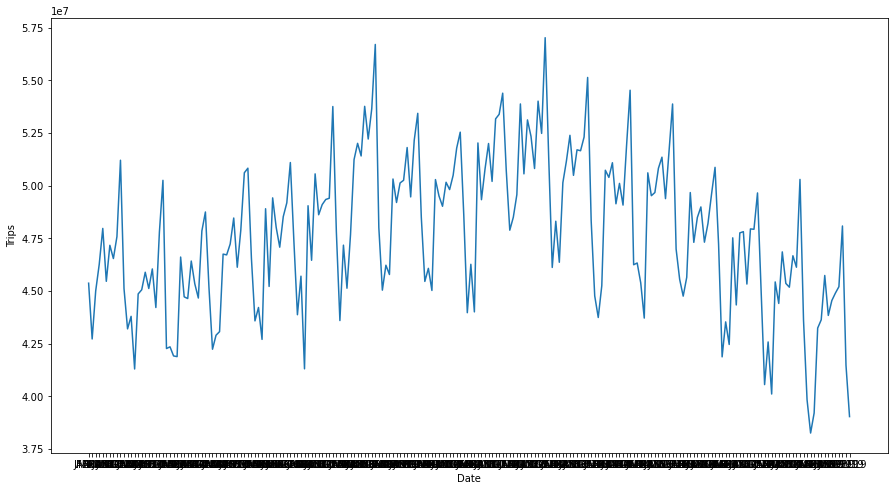

In [7]:
plt.figure(figsize=(15,8))
sns.lineplot(data=chicago_df, x='Date', y='Trips')

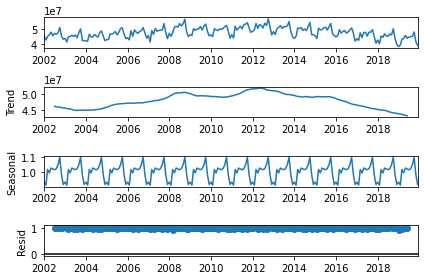

In [8]:
df2 = chicago_df.copy()
df2['Date'] = pd.to_datetime(df2['Date'], format='%b%y')
df2.set_index('Date', inplace=True)

analysis = df2[['Trips']].copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [9]:
# EXPLORE - IS OUR TIME SERIES STATIONARY OR NOT?

result = adfuller(chicago_df['Trips'], autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(f"%1 :{result[4].get('1%')}")
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.022316
p-value: 0.745038
Critical Values:
%1 :-3.4633090972761744
	1%: -3.463
	5%: -2.876
	10%: -2.574


In [10]:
# SCRUB - OUR TIME SERIES IS NOT STATIONARY - WE NEED TO TAKE THE DIFFERENCE
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [11]:
pvalues = list()

for i in range(1,12):
	X = chicago_df['Trips'].values
	stationary = difference(X, i)
	stationary.index = chicago_df.index[i:]
	# check if stationary
	result = adfuller(stationary)
	pvalues.append(result[1])
	#print('ADF Statistic: %f' % result[0])
	print('p-value: %f' % result[1])
	#print('Critical Values:')
	#for key, value in result[4].items():
		#print('\t%s: %.3f' % (key, value))

# plot
#stationary.plot()

p-value: 0.040324
p-value: 0.042945
p-value: 0.045484
p-value: 0.041598
p-value: 0.064462
p-value: 0.047620
p-value: 0.021730
p-value: 0.000111
p-value: 0.002302
p-value: 0.005332
p-value: 0.013049


<AxesSubplot:>

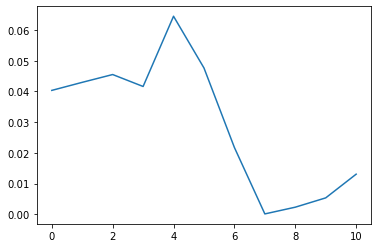

In [12]:
pd.Series(pvalues).plot()

ADF Statistic: -4.636319
p-value: 0.000111
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


<AxesSubplot:>

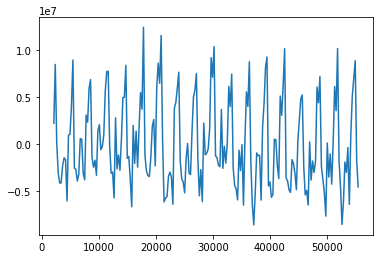

In [13]:
X = chicago_df['Trips'].values
stationary = difference(X, 8)
stationary.index = chicago_df.index[8:]
# check if stationary
result = adfuller(stationary)
pvalues.append(result[1])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# plot
stationary.plot()

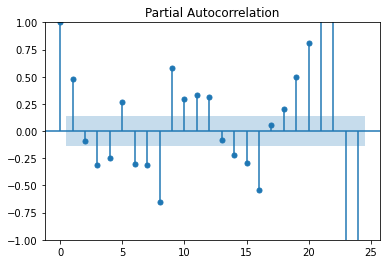

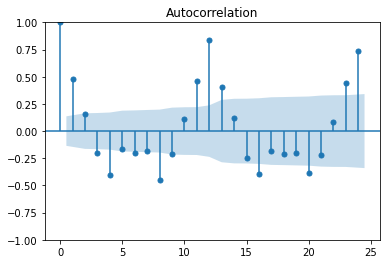

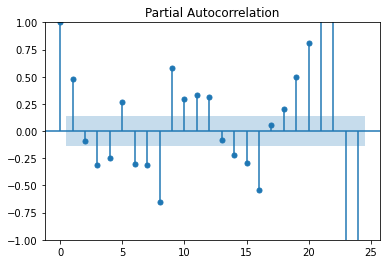

In [14]:
# USING STATIONARY TIME SERIES LOOK AT ACF

series = stationary

plot_acf(series)
plot_pacf(series)

In [15]:
# SCRUB - SOME CODE TO INVERT DIFFERENCE VALUE

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

RMSE: 1231234.106


<AxesSubplot:>

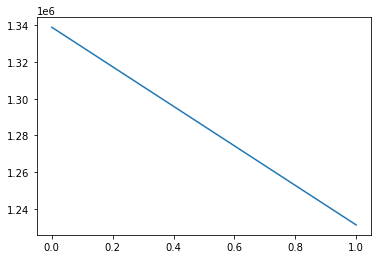

In [34]:
# BUILD THE MODEL - USING ORIGINAL SERIES1 DATA

# prepare data
X = chicago_df['Trips'].values
X = X.astype('float32')
train_size = int(len(X) * 0.75)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	try:
		# difference data
		weeks_in_year = 8
		diff = difference(history, weeks_in_year)
		# predict
	
		model = ARIMA(diff, order=(9,1,9))
		model_fit = model.fit()
		yhat = model_fit.forecast()
		yhat = inverse_difference(history, yhat, weeks_in_year)
		predictions.append(yhat)
		# observation
		obs = test[i]
		history.append(obs)
		#print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
	except:
		pass
		# ignore the error and go on
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
rmse_list.append(rmse)

#pd.Series(rmse_list).plot()


In [28]:
#rmse_df = pd.DataFrame(data={'p':p_list,'q':q_list,'r':r_list,'rmse':rmse_list})
rmse_df.to_csv("data/rmse_df.csv", sep=",", index=False)